In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime
from io import StringIO

In [2]:
def conv2space(imuang, x = np.array([0,0,-1]), L = 1.0):
    X = x*L
    C = []
    S = []
    imupi = (imuang/180) *math.pi
    for theta in imupi:
        C.append(math.cos(theta))
        S.append(math.sin(theta))

    R_yrp = np.array([ [C[2]*C[1] - S[2]*C[0]*S[1] , -C[2]*S[1] - S[2]*C[0]*C[1] , S[2]*S[0] ],
                          [ C[2]*C[0]*S[1] +S[2]*C[1], C[2]*C[0]*C[1] - S[2]*S[1], -C[2]*S[0] ],
                         [ S[0]*S[1], S[0]*C[1], C[0] ] ])

    #Thigh / Calf/ Ankle Length
# C 1 C 3 - S 1 C 2 S 3   /   - C 1 S 3 -S 1 C 2 C 3   /   S 1 S 2
#C 1 C 2 S 3 + S 1 C 3   /   C 1 C 2 C 3 - S 1 S 3   /   - C 1 S 2
# S 2 S 3   /   S 2 C 3   /   C 2
# Ref. Analysis of Euler Angles in a Simple Two-Axis Gimbals Set, Table 1. ZXZ intrincsic rotations
#1 -> Yaw, [2]
#2 -> Roll, [0]
#3 -> Pitch, [1]

    return np.matmul( R_yrp, X)
print (conv2space(np.array([90,90,90]), np.array([1,0,0])))


[ -6.12323400e-17   6.12323400e-17   1.00000000e+00]


In [5]:
TimeStamp = []
Array = []
arrays = [['imu1','imu2', 'imu3', 'imu4', 'imu5', 'imu6', 'imu7', 'imu8' ],['roll','pitch','yaw'] ]
columns = pd.MultiIndex.from_product(arrays, names=['IMUs','Coord'])
#==========Load from the saved Numpy array angular data(Z,X,Z Intrincsic, roll, pitch, yaw)
with open('/home/june/Desktop/WordkingOn/pgas/data/2017-03-21T15-53-21-walk.csv', 'r') as arr:
    TimeStamp.append(arr.readline().strip('# ').strip('\n'))
    for readline in arr.readlines():
        Array.append(readline.strip('\n').split(','))
    TimeStamp.append(Array.pop()[0].strip('# '))
timedelta = (datetime.strptime(TimeStamp[1], "%Y-%m-%dT%H:%M:%S.%f") -datetime.strptime(TimeStamp[0], "%Y-%m-%dT%H:%M:%S.%f") ).total_seconds()
IMU_raw = pd.DataFrame(np.array(Array, dtype = float), columns = columns)
#==========Convert into the spatial coordinate with [0,0,-1] with length 1======
IMUspace = IMU_raw.copy(deep=True)
for imu in columns.levels[0]:
    IMUspace[imu] = IMU_raw[imu].apply(conv2space, axis = 1)

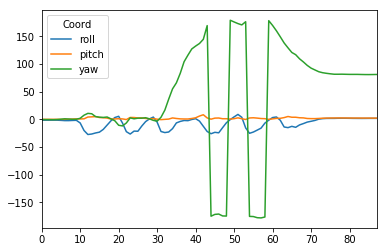

In [9]:
IMU_raw.imu3.plot()
plt.show()

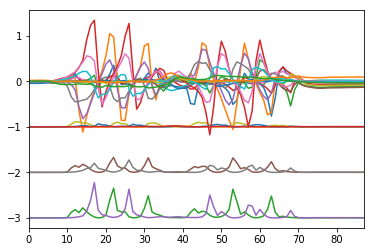

In [28]:
IMUcum = IMUspace.copy(deep=True)
IMUcum.imu2 = IMUspace.imu3 + IMUspace.imu2
IMUcum.imu1 = IMUspace.imu3 + IMUspace.imu2 +IMUspace.imu1

IMUcum.imu6 = IMUspace.imu6 + IMUspace.imu7
IMUcum.imu5 = IMUspace.imu5 + IMUspace.imu6 + IMUspace.imu7
#IMUcum.imu1.pitch.plot()
#plt.show()
IMUcum.plot(legend=False)
plt.show()

In [ ]:
g